In [1]:
%matplotlib inline
# %autosave 60

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import copy
import scipy.optimize
import time
import pickle as pkl

from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic

In [2]:
def gaussian_blur_image(arcImg, configDict):
    gaussianBlurSigma = configDict['gaussianBlurSigma']
    arcImgCp = gaussian_filter(arcImg, sigma=gaussianBlurSigma)
    
    return arcImgCp

def make_threshold_image(arcImg, configDict):
    threshold = configDict['threshold']
    mu = arcImg[arcImg>0].mean()
    sigma = arcImg[arcImg>0].std()
#     threshold = mu - 2 * sigma
#     threshold = 0.3
    arcImgCp = gaussian_blur_image(arcImg, configDict)
    brightPxs = np.zeros(arcImg.shape)
    brightPxs[arcImgCp > threshold] = 1
    
    return brightPxs

In [3]:
def convert_fov_degs_px(whDeg, plateScale):
    wDeg, hDeg = whDeg
    nXPx = wDeg * 3600 / plateScale
    nYPx = hDeg * 3600 / plateScale
    whPx = (int(nXPx), int(nYPx))
    
    return whPx

In [4]:
def antidifferentiate_rotation_matrix(phiDot, t):
    rotMatrixAntidifferentiated = np.array([[np.sin(phiDot * t), np.cos(phiDot * t)], 
                                           [-np.cos(phiDot * t), np.sin(phiDot * t)]]) / phiDot
    return rotMatrixAntidifferentiated

def integrate_drift(initialDrift, phiDot, t_final, t_initial=0):
    rotMatrixIntegrated = antidifferentiate_rotation_matrix(phiDot, t_final) - \
                          antidifferentiate_rotation_matrix(phiDot, t_initial)
    integratedDrift = np.matmul(rotMatrixIntegrated, initialDrift)
    
    return integratedDrift

In [5]:
def xy_image_coord_transform(r, img, inverse=False):
    # Works with arrays of shape (2,) and (2, N)
    height, width = img.shape
    
    if inverse:
        rPrime0 = r[1]
        rPrime1 = height - r[0]
    else:
        rPrime0 = height - r[1]
        rPrime1 = r[0]

    rPrime = np.array([rPrime0, rPrime1]).reshape(r.shape)
    
    return rPrime

In [6]:
def score_center(center, img, dr):
    # Center in image coords (row, col)
    height, width = img.shape
    maxR = np.linalg.norm(np.array([height, width]))
    rBins = np.arange(0, int(maxR + 1), dr)
    
    # Calculate bright px distances from given center
    center = center.reshape((2, 1))
    rowBright, colBright = np.where(img > 0)
    brightIdx = np.vstack([rowBright, colBright])
    rBright = brightIdx - center
    rBright = np.linalg.norm(rBright, axis=0)
    
    # Calculate score
    nBrightInBin, binEdges = np.histogram(rBright, bins=rBins)
    brightRadii = binEdges[1:][nBrightInBin > 0]
        
    score = len(brightRadii)
    
    return score

In [7]:
def show_arc_image(img, saveFig=False, figsDir='', figName='arc_image.png'):
    fig, ax = plt.subplots(figsize = (20, 20))
    ax.imshow(img, cmap='gray')#, interpolation='none')
    
    if saveFig:
        filename = os.path.join(figsDir, figName)
        fig.savefig(filename)

    plt.show()
    
def plot_scores(scoreIm, scoreType, saveFig=False, figsDir='', figName='center_scores.png'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    im = ax.imshow(scoreIm)
    ax.set_title(f'{scoreType} Score Near Pointing Center', fontsize=22)
    ax.tick_params(labelsize=14)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Score', fontsize=18)
    cbar.ax.tick_params(labelsize=14)
    
    if saveFig:
        filename = os.path.join(figsDir, figName)
        fig.savefig(filename)

    plt.show(fig)

In [8]:
def make_arc_image(configDict, seed=None):
    expTime = configDict['expTime']
    slewRate = configDict['slewRate']
    width = configDict['imageWidth']
    height = configDict['imageHeight']
    driftVel = configDict['driftVel']
    rng = configDict['rng']
    xMu = configDict['xMu']
    yMu = configDict['yMu']
    pointingSigma = configDict['pointingSigma']
    nStars = configDict['nStars'] 

    fCircle = expTime * slewRate / 360
    phiDot = slewRate * np.pi / 180
    
    vals = rng.standard_normal(2) # Sample gaussian twice

    # Define pointing center
    pointingCenter = np.array([xMu + pointingSigma * vals[0], yMu + pointingSigma * vals[1]]) # x and y
    
    # Add pointingCenter to configDict
    configDict['pointingCenter'] = pointingCenter
    
#     maxRadius = np.sqrt(width**2 + height**2)/np.sqrt(2) # in px
#     totalAngle = np.pi * expTime * slewRate / 180
    tSteps = int(20000 * fCircle * 4)
    dt = expTime / tSteps
    times = np.arange(0, expTime + dt, dt)

    # Make an array for later use
    arcImg = np.zeros((height, width))

    for i in range(nStars): # Pretty sure this entire operation can be vectorized (tensorized)
        xExt0 = width * rng.random()
        yExt0 = height * rng.random()
        rExt0 = np.array([xExt0, yExt0])
#         rExt = rExt0 + driftVel.flatten()
#         rExt = rExt.reshape((2, 1))
        integratedDrift_t = times * driftVel
        rExt_t = rExt0.reshape((2, 1)) + integratedDrift_t
        rotM_t = np.array([[[np.cos(phiDot * t), -np.sin(phiDot * t)], 
                            [np.sin(phiDot * t), np.cos(phiDot * t)]] for t in times])
        
        rPrime_t = rExt_t - pointingCenter.reshape((2, 1))
        rPrime_t = rPrime_t.transpose().reshape((rotM_t.shape[0], 2, 1))
        rCam_t = np.matmul(rotM_t, rPrime_t)
        rCam_t = rCam_t.transpose(0, 2, 1).squeeze()
        rCam_t = np.round(rCam_t)
        
        dataType = np.dtype([('x', rCam_t.dtype), ('y', rCam_t.dtype)])
        dataVectors = rCam_t.view(dtype=dataType).squeeze()
        uniqueVectors = np.array(np.unique(dataVectors).tolist())
        
        for rPrime in uniqueVectors:            
#         radius = maxRadius * rng.random()
#         theta0 = np.pi * 2 * rng.random() ## Comment out for demo images
#         dTheta = totalAngle / tSteps
#         rPrime0 = radius * np.array([np.cos(theta0), np.sin(theta0)])
#         r0 = pointingCenter + rPrime0
#         r0 = r0.reshape(2, 1)
#         rPrime0 = rPrime0.reshape(2, 1)
        
#         for i in range(tSteps):
#             rotM = np.array([[np.cos(i * dTheta), -np.sin(i * dTheta)], [np.sin(i * dTheta), np.cos(i * dTheta)]])
#             rPrime = np.matmul(rotM, rPrime0 + driftVel * i * dt).flatten()
            r = pointingCenter + rPrime
            imgIdx = xy_image_coord_transform(r, arcImg)
            row = int(imgIdx[0])
            col = int(imgIdx[1])

            # Some arcs will go out of the image
            if row >= 0 and col >= 0:   
                try:
                    arcImg[(row, col)] += 1
                except IndexError:
                    pass
                
    return arcImg

In [9]:
def measure_drift_effect(configDict):
    threshold = configDict['threshold']
    
    arcImg = make_arc_image(configDict)
    pointingCenter = configDict['pointingCenter']
    pcIdx = xy_image_coord_transform(pointingCenter, arcImg)
    arcImgCp = gaussian_filter(arcImg, sigma=gaussianBlurSigma)
    brightPxs = np.zeros(arcImg.shape)
    brightPxs[arcImgCp > threshold] = 1
    arguments = (brightPxs, )
    deRes = scipy.optimize.differential_evolution(score_center, ((0, height), (0, width)), 
                                                  args=arguments)
    optimizerError = pcIdx - deRes.x
#     optimizerErrorXY = xy_image_coord_transform(optimizerError, brightPxs, inverse=True)
    
    return optimizerError

In [14]:
# Instrument Specs
focalLengths = [135, 375, 750]
whDegs = [(7.91, 5.93), (2.85, 2.13), (1.42, 1.07)] # Image width and height in Degrees
plateScales = [8.64, 3.11, 1.56] # plate scales of cameras in arcsec / px
whPxs = [convert_fov_degs_px(whDeg, plateScale) for whDeg, plateScale in zip(whDegs, plateScales)] 

# Notebook Configurables
camNum = 0 # Choose an instrument
slewRate = 6 # degs / s
driftDir = np.array([[1],[0]]) # Drifting right in px space initially
driftSpeedArcSec = 10 # arcseconds / s
threshold = 0.3 # Bright pixel Threshold
gaussianBlurSigma = 1 # PSF width
pointingSigma = 300 # STD of pointings around image center
expTime = 15 # seconds
seed = None # 98735927 # Set a seed (optional)
figsDir = os.path.expanduser('~/Pictures/work/lsst/startracker/simulate_drift') # Where to save the figures
saveFig = False
dr = 1 # Radial bin width for Scoring Center
nStars = 35

# Parameters Derived / Selected from Configurables
driftSpeedDeg = driftSpeedArcSec / 3600 # deg / s 
focalLength = focalLengths[camNum]
plateScale = plateScales[camNum]
width, height = whPxs[camNum]
driftVel = driftSpeedArcSec / (plateScale) * driftDir # Drift in px / s
xMu = width / 2 
yMu = height / 2

# numpy random Stuff
if seed is None:
    rng = np.random.default_rng() # Make one of these things
else:
    rng = np.random.default_rng(seed)

# Dictionary of Configurables to pass to functions
configDict = {
    'expTime': expTime,
    'slewRate': slewRate,
    'driftVel': driftVel,
    'threshold': threshold,
    'rng': rng,
    'imageWidth': width,
    'imageHeight': height,
    'gaussianBlurSigma': gaussianBlurSigma,
    'xMu': xMu,
    'yMu': yMu,
    'pointingSigma': pointingSigma,
    'nStars': nStars
}

In [11]:
# for i in range(nImages):
arcImg = make_arc_image(configDict)
# blurredImg = gaussian_blur_image(arcImg, configDict)
pointingCenter = configDict['pointingCenter']
brightPxs = make_threshold_image(arcImg, configDict)

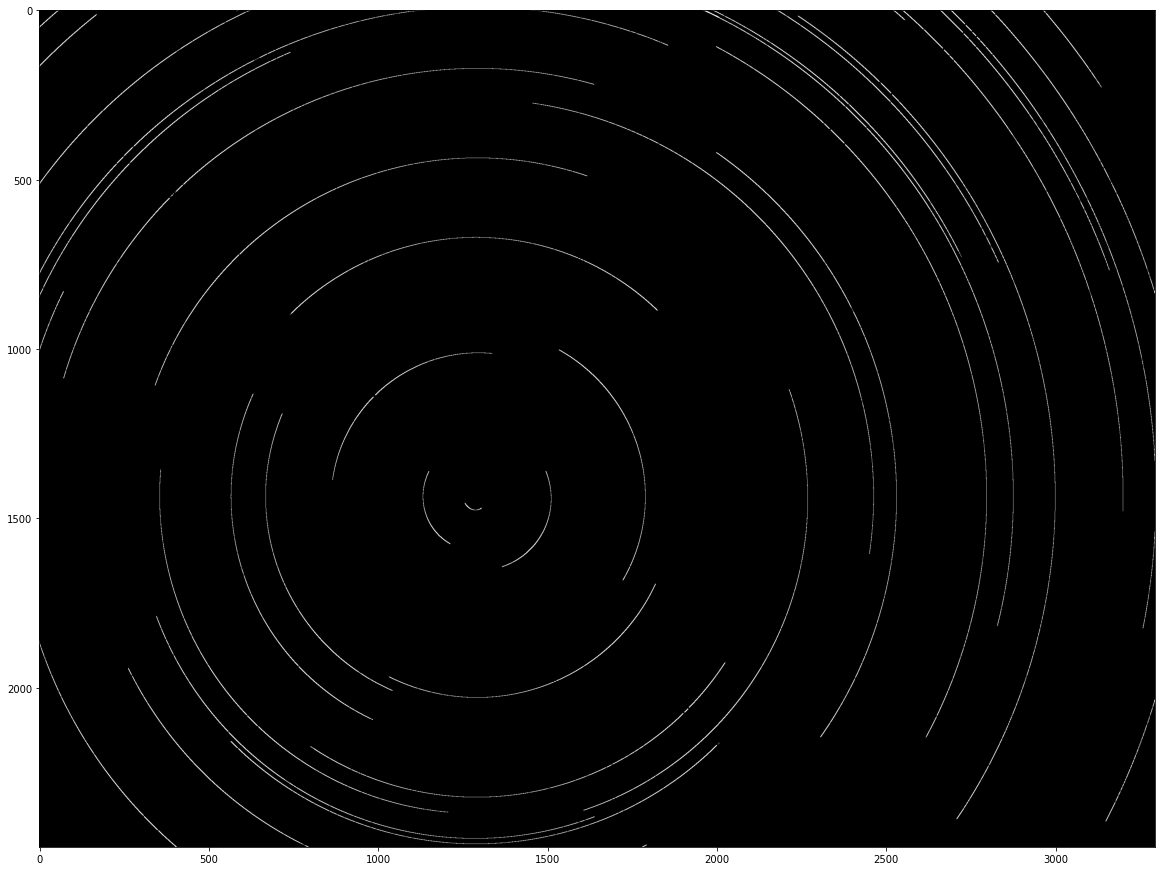

In [12]:
# figName = f'drift{driftSpeedArcSec}_arc_image.png'
# show_arc_image(arcImg, saveFig=saveFig, figsDir=figsDir, figName=figName)
figNameThresholded = f'drift{driftSpeedArcSec}_thresholded_arc_image.png'
show_arc_image(brightPxs, saveFig=saveFig, figsDir=figsDir, figName=figNameThresholded)

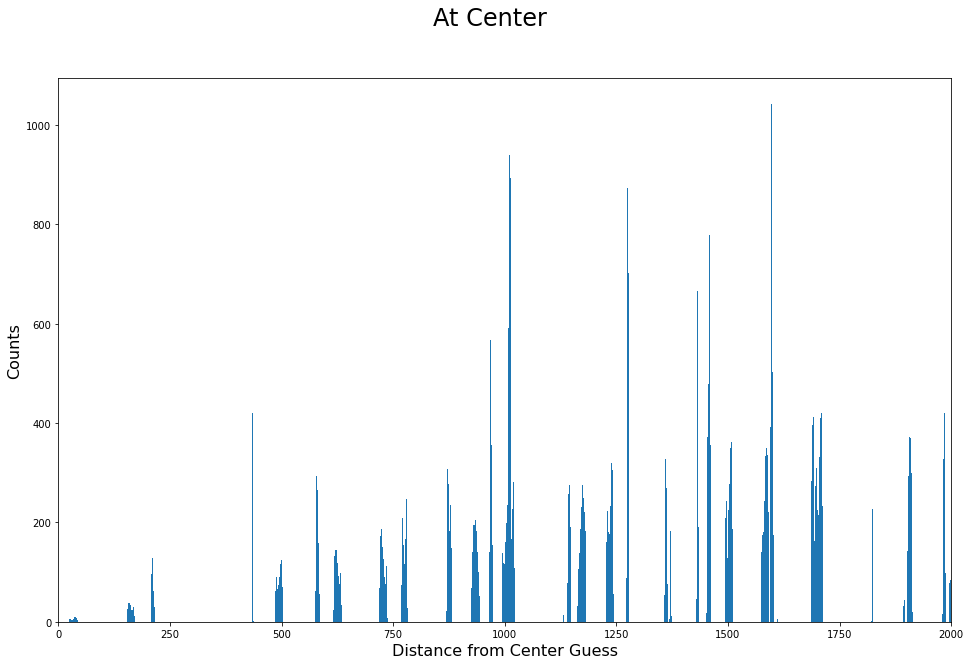

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
height, width = brightPxs.shape
maxR = np.linalg.norm(np.array([height, width]))
rBins = np.arange(0, int(maxR + 1), dr)
   
# Calculate bright px distances from given center
center = xy_image_coord_transform(pointingCenter, arcImg)
# center = np.array([1300, 1600])
center = center.reshape((2, 1))
rowBright, colBright = np.where(brightPxs > 0)
brightIdx = np.vstack([rowBright, colBright])
rBright = brightIdx - center
rBright = np.linalg.norm(rBright, axis=0)

ax.hist(rBright, bins=rBins)
ax.set_ylabel('Counts', fontsize=16)
ax.set_xlabel('Distance from Center Guess', fontsize=16)
ax.set_xlim(0, 2000)
fig.suptitle('At Center', fontsize=24)
plt.show()

In [16]:
radScores = np.zeros(brightPxs.shape)
pcIdx = xy_image_coord_transform(pointingCenter, arcImg)
rowMin, rowMax = (int(pcIdx[0]-50), int(pcIdx[0]+50))
colMin, colMax = (int(pcIdx[1]-50), int(pcIdx[1]+50))

for irow in range(rowMin, rowMax):
    for icol in range(colMin, colMax):
        c = np.array([irow, icol])
        radScores[irow, icol] = score_center(c, brightPxs, dr)

radScores = radScores[rowMin:rowMax, colMin:colMax]

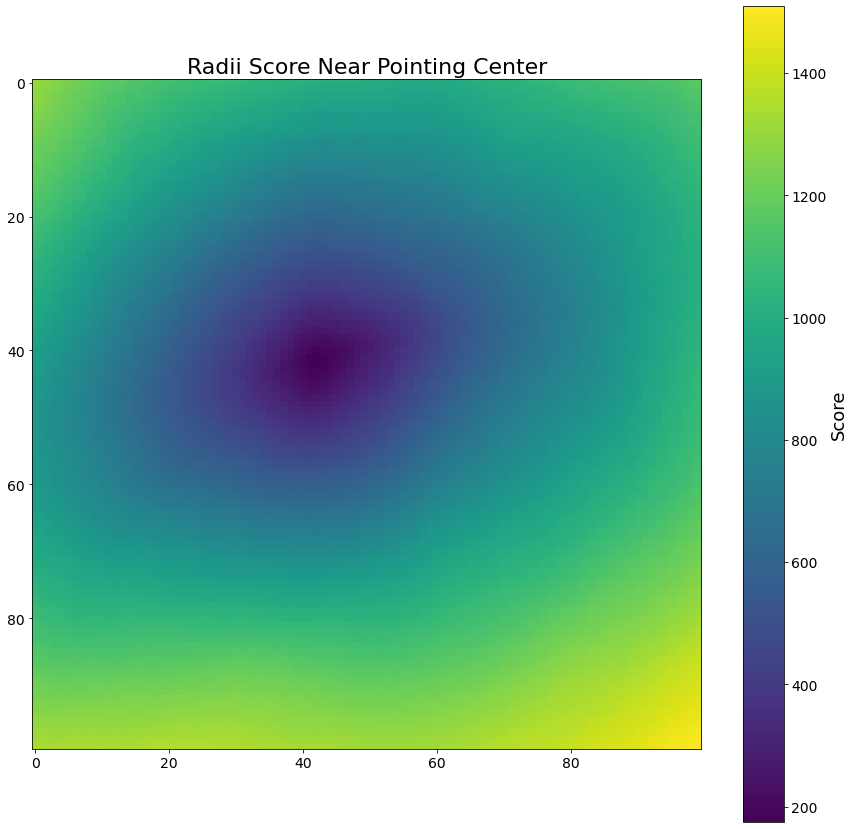

In [17]:
figName = f'drift{driftSpeedArcSec}_radii_center_scores.png'
plot_scores(radScores, 'Radii', saveFig=saveFig, 
            figsDir=figsDir, figName=figName)

In [18]:
drifts = np.arange(0, 16, 3)
nTrials = 10
optErrors = np.zeros((nTrials, len(drifts), 2))
threshold = configDict['threshold']

for iDrift, drift in enumerate(drifts):
    driftVel = drift / (plateScale) * driftDir # Drift in px / s
    configDict['driftVel'] = driftVel
    arcImg = make_arc_image(configDict)
    pointingCenter = configDict['pointingCenter']  
    pcIdx = xy_image_coord_transform(pointingCenter, arcImg)
    arcImgCp = gaussian_filter(arcImg, sigma=gaussianBlurSigma)
    brightPxs = np.zeros(arcImg.shape)
    brightPxs[arcImgCp > threshold] = 1
    arguments = (brightPxs, dr)
    
    for iTrial in range(nTrials):
        deRes = scipy.optimize.differential_evolution(score_center, ((0, height), (0, width)), 
                                                      args=arguments)
        optimizerError = pcIdx - deRes.x
        optErrors[iTrial, iDrift] = optimizerError
        
optErrors = optErrors.transpose(0, 2, 1)

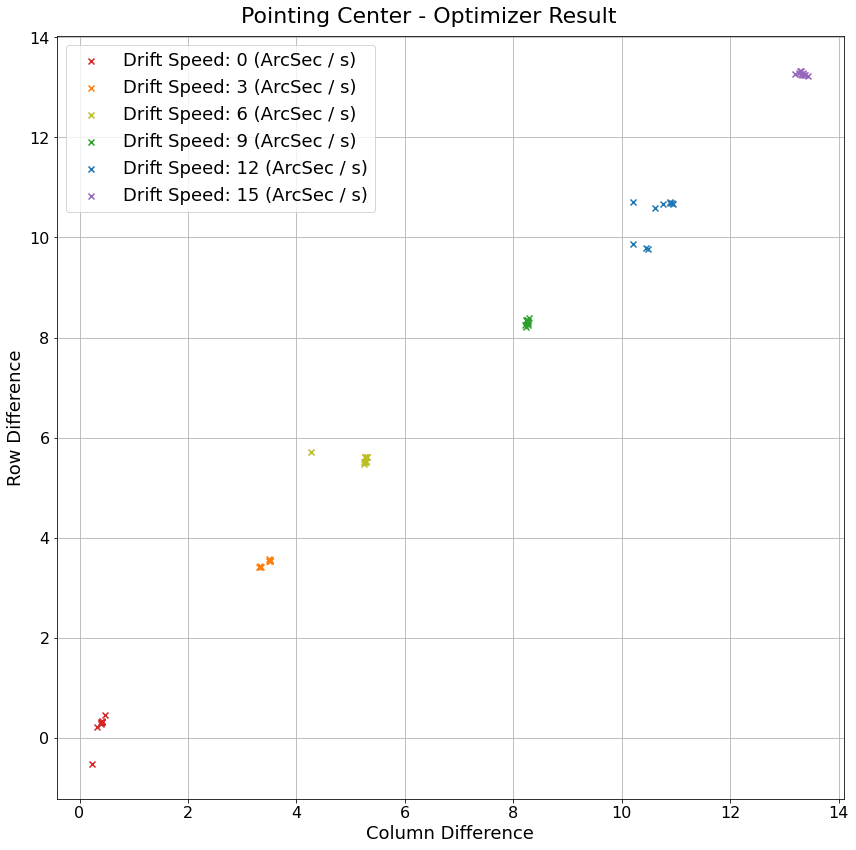

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
fig.suptitle('Pointing Center - Optimizer Result', fontsize=22)
ax.set_ylabel('Row Difference', fontsize=18)
ax.set_xlabel('Column Difference', fontsize=18)
# ax.set_xlim(-1, 14)
# ax.set_ylim(-1, 14)
ax.tick_params(labelsize=16)
ax.grid(visible=True)

colors = ['tab:red', 'tab:orange', 'tab:olive', 'tab:green', 'tab:blue', 'tab:purple']

for iDrift, drift in enumerate(drifts):
    optErrorData = optErrors[:, :, iDrift].transpose()
    x = optErrorData[1]
    y = optErrorData[0]
    ax.scatter(x, y, marker='x', label=f'Drift Speed: {drift} (ArcSec / s)', color=colors[iDrift])
    
ax.legend(fontsize=18)
fig.tight_layout()
fName = 'drift_effect.png'
fileName = os.path.join(figsDir, fName)
fig.savefig(fileName)
plt.show(fig)

In [ ]:
hyperparams = [(0.01, 3), (0.01, 1), (0.002, 3), (0.002, 1)]
nTrials = 20
arcImg = make_arc_image(configDict)
arcImgCp = gaussian_filter(arcImg, sigma=gaussianBlurSigma)
brightPxs = np.zeros(arcImg.shape)
brightPxs[arcImgCp > threshold] = 1

optimizerResults = np.zeros((len(hyperparams), nTrials, 2))

for iHyper, (tol, dr) in enumerate(hyperparams):
    arguments = (brightPxs, dr)
    
    for iTrial in range(nTrials):
        deRes = scipy.optimize.differential_evolution(score_center, ((0, height), (0, width)), 
                                                      args=arguments, tol=tol)
        optimizerResults[iHyper, iTrial] = deRes.x

In [ ]:
pklFileName = 'optimizerErrors.pkl'
with open(pklFileName, 'wb') as f:
    pkl.dump(optimizerErrors, f)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14),)
fig.suptitle('Pointing Center - Score Minima', fontsize=22)

for optErr, ax, (tol, dr) in zip(optimizerErrors, axs.ravel(), hyperparams):
    row = optErr[:, 0]
    col = optErr[:, 1]
    print(optErr.std(axis=0, ddof=1))
    ax.scatter(col, row)
    ax.set_title(f'tol={tol}, dr={dr}', fontsize=16)
    ax.tick_params(labelsize=16)
    ax.set_ylabel('Row', fontsize=18)
    ax.set_xlabel('Column', fontsize=18)
    ax.set_ylim(-.8, 0)
    ax.set_xlim(-.8, 0)

plt.show()